In [26]:
"""
Re‑creates your current world + camera demo and opens a matplotlib window.
Run:  python -m examples.demo_world
"""
import numpy as np
from nerflab import (
    Intrinsics, Camera, Box, Sphere, World,
    stratified_samples_batch, plot_world, CFG, pose_H, make_pose_cases
)


In [27]:
CFG.intrinsics

IntrinsicsCfg(fx=1200, fy=1200, width=640, height=480)

In [28]:
# --- build world -------------------------------------------------------------
world = World()
world.add_shape(Box(center=(-1.5,  0.0, -2), size=(1.4, 1.4, 1.4)))
world.add_shape(Box(center=( 1.4,  0.6, -1), size=(1.0, 1.6, 1.0)))
world.add_shape(Box(center=( 0.0, -1.2,  0), size=(1.0, 1.0, 1.8)))
world.add_shape(Sphere(center=(-0.8, 1.2, -2),  radius=0.85))
world.add_shape(Sphere(center=( 1.6,-0.8, -1.5), radius=0.70))

# Check the density of a point
x,y,z = (0,2,1)
print("density at (0,2,1):", world.density(x, y, z))


density at (0,2,1): 0.0


In [29]:
# build preset dictionary
cases = make_pose_cases(axis_dist=10)

# pick a view (e.g., diagonal)
H_wc = pose_H(cases["+Z"])  
print(H_wc)

[[ 1.  0. -0.  0.]
 [-0.  1. -0.  0.]
 [ 0.  0.  1. 10.]
 [ 0.  0.  0.  1.]]


points shape: (307200, 20, 3)


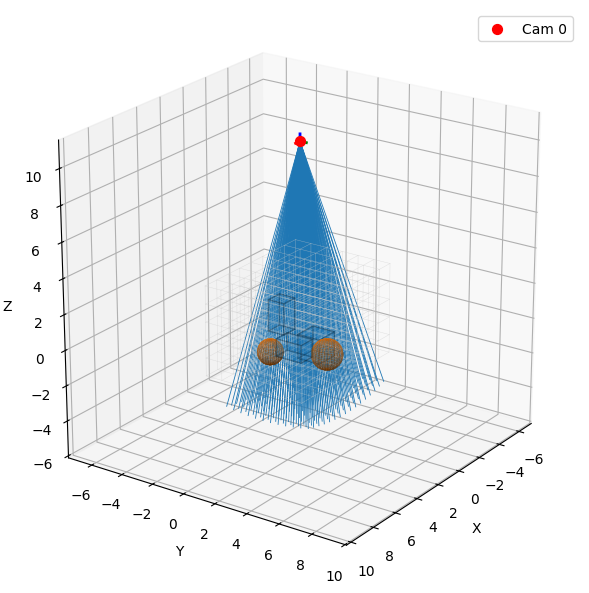

In [31]:
# --- camera ------------------------------------------------------------------
# H_wc = np.eye(4, dtype=np.float32)        # simple origin‑facing camera
intr  = Intrinsics(**CFG.intrinsics.__dict__)
cam   = Camera(intr, H_wc,
               t_bounds=(CFG.rays.t_near, CFG.rays.t_far))

# --- sample rays -------------------------------------------------------------
O_w, D_w = cam.get_rays(frame="world")
t, delta, pts = stratified_samples_batch(
    O_w, D_w, CFG.rays.t_near, CFG.rays.t_far,
    N=CFG.rays.N, deterministic=CFG.rays.deterministic
)
print("points shape:", pts.shape)

# --- visualise ---------------------------------------------------------------
plot_world(world,
           cameras=[cam],
           draw_rays=True,
           ray_step=CFG.plot.step,
           grid_lines=True, 
           grid_step=(1,1,1))


In [32]:
print(cam.print_info())

=== Camera ===
Res: 480 x 640
fx, fy: 1200.00, 1200.00
cx, cy: 320.00, 240.00
t_bounds: [10, 15]
H_wc:
 [[ 1.  0. -0.  0.]
 [-0.  1. -0.  0.]
 [ 0.  0.  1. 10.]
 [ 0.  0.  0.  1.]]
None


In [33]:
from nerflab import sigma_from_world
sigma = sigma_from_world(world, pts)

In [34]:
from nerflab import nerf_opacity
T, w, C = nerf_opacity(sigma, delta)
print(sigma.shape)
print(pts.shape)
print(C.shape)

(307200, 20)
(307200, 20, 3)
(307200,)


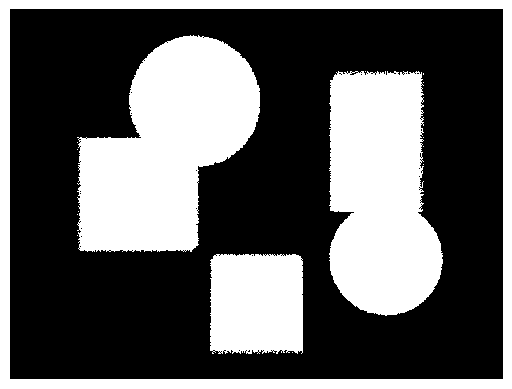

In [35]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap, BoundaryNorm

h, w = int(intr.height), int(intr.width)
im = np.round(C.reshape(h,  w), 2)

# im is 0/1 array
cmap = ListedColormap(['black', 'white'])
norm = BoundaryNorm([-0.5, 0.5, 1.5], cmap.N)

plt.imshow(im, cmap=cmap, norm=norm, interpolation='nearest')
plt.axis('off')
plt.show()


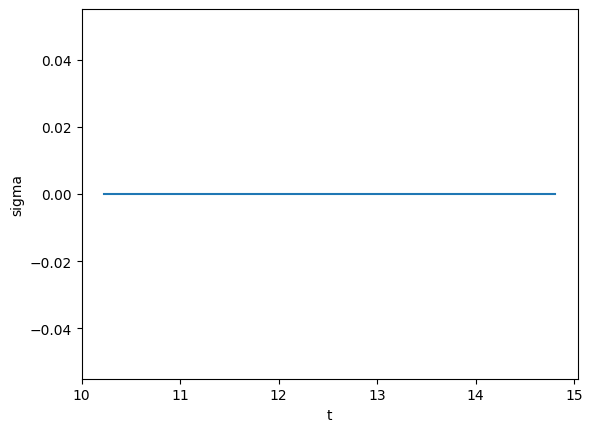

In [36]:
plt.plot(t[1000], np.clip(sigma[10000], 0, 1000))
plt.xlabel("t")
plt.ylabel("sigma")
plt.show()

In [37]:
# Debug once

bad_sigma = ~np.isfinite(sigma)
bad_delta = ~np.isfinite(delta)
print("bad sigma:", bad_sigma.any(), "bad delta:", bad_delta.any())


bad sigma: False bad delta: False
